# Classification with linear and logistic regression
Author: **[Carl McBride Ellis](https://u-tad.com/claustro/carl-mcbride-ellis/)**

In [30]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 30)

import numpy as np

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
#plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = (20,5)

np.random.seed(42)

# Create some synthetic data

In [31]:
mu        = 190
sigma     = 50
n_numbers = 500

data = (np.random.randn(n_numbers) * sigma + mu).astype('int')
times = data.tolist()

X  = np.arange(0,241)
df = pd.DataFrame(X, columns = ['X'])
df["y"] = 0

for i in times:
    if i <= 240:
        df.loc[i, "y"] = 1

X = df["X"].values
y = df["y"]

In [32]:
df.head()

,X,y
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0


# Plot our synthetic data

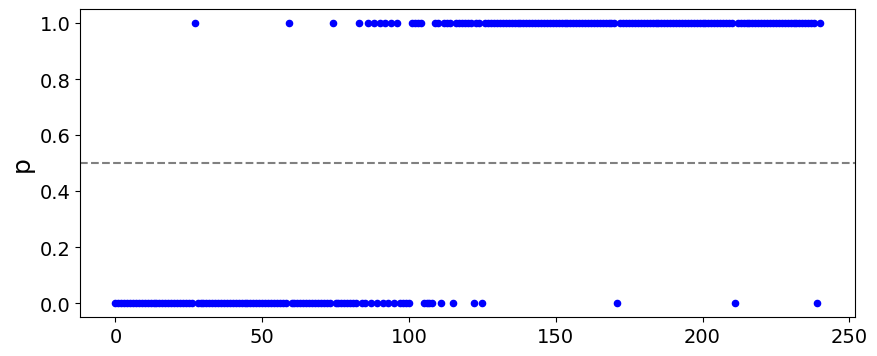

In [33]:
fig, ax = plt.subplots(figsize=(10, 4))
plt.scatter(df["X"], df["y"], color="blue", s=20)
plt.axhline(y=0.5, color='grey', linestyle='--')
ax.set_ylabel ("p", fontsize=18);

## Linear probability model

In [34]:
def OLS(x, y):
    beta_1 = (np.sum((x - np.mean(x))*(y - np.mean(y))))/ \
    (np.sum((x - np.mean(x))**2))
    beta_0 = np.mean(y) - (beta_1*np.mean(x))
    return beta_1, beta_0

beta_1, beta_0 = OLS(df["X"], df["y"])

print(beta_1, beta_0)

df["linear_probability"] = beta_1*df["X"] + beta_0

0.0055373615445286515 -0.08771989986625983


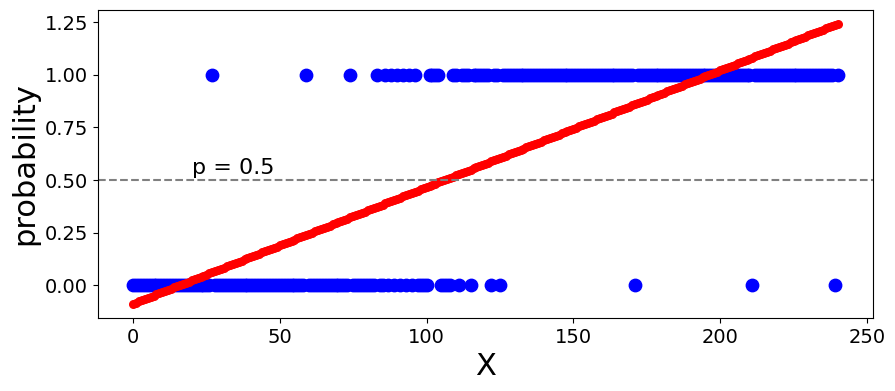

In [35]:
fig, ax = plt.subplots(figsize=(10, 4))
plt.scatter(df["X"], df["y"], color="blue", s=80)
plt.scatter(df["X"], df["linear_probability"], color="red",s=30)
plt.axhline(y=0.5, color='grey', linestyle='--')
ax.set_ylabel ("p", fontsize=18)
ax.set_ylabel ("probability", fontsize=22);
ax.set_xlabel ("X", fontsize=22);
ax.text(20, 0.53, "p = 0.5", size=16);

In [36]:
def perceptron(X, beta, d = 0.5):
    X1 = np.column_stack( (X, np.ones(len(X))) )
    p = X1 @ beta # p is our probability
    y = np.heaviside( p-d, 0)
    return y

In [37]:
beta = np.array([beta_1, beta_0])
df["linear_class"] = perceptron(df["X"].values, beta)

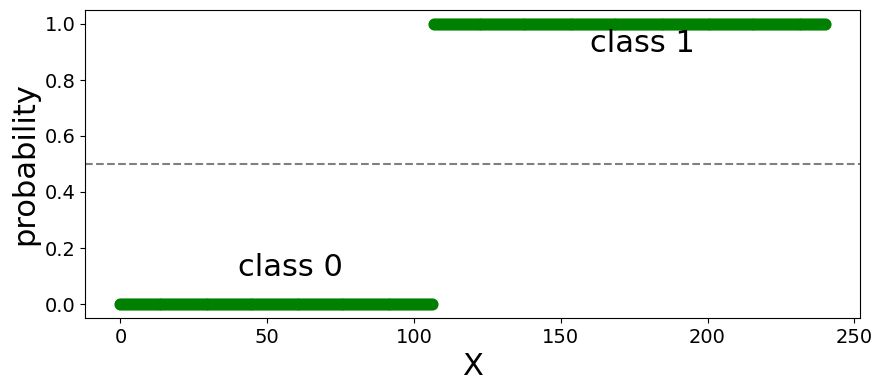

In [38]:
fig, ax = plt.subplots(figsize=(10, 4))
#plt.scatter(X, df.y, color="blue", s=80)
plt.scatter(X, df["linear_class"], color="green",s=60)
# decoration
plt.axhline(y=0.5, color='grey', linestyle='--')
ax.set_ylabel ("p", fontsize=18)
ax.set_ylabel ("probability", fontsize=22);
ax.set_xlabel ("X", fontsize=22);
ax.text(160, 0.9, "class 1", size=22)
ax.text(40, 0.1, "class 0", size=22);

# Fit using scikit-learn [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

In [39]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(penalty= None,
                                max_iter= 100,
                                tol= 0.0001,
                                solver='lbfgs',
                                fit_intercept= True)

classifier.fit(X.reshape(-1, 1), y)

# calculate the probabilitiies
df["logistic_probability"]  = classifier.predict_proba(X.reshape(-1, 1))[:,1]

/home/juan/AI/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


In [40]:
kappa_1 = classifier.coef_[0]
kappa_0 = classifier.intercept_

print(kappa_1, kappa_0)

[0.05042536] [-5.11322362]


# Plot our logistic regression fit

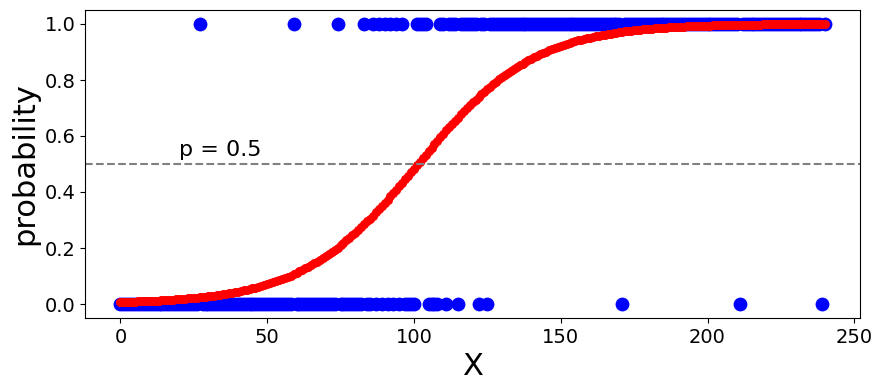

In [41]:
fig, ax = plt.subplots(figsize=(10, 4))
plt.scatter(df["X"], df["y"], color="blue", s=80)
plt.scatter(df["X"], df["logistic_probability"], color="red",s=30)
plt.axhline(y=0.5, color='grey', linestyle='--')
ax.set_ylabel ("p", fontsize=18)
ax.set_ylabel ("probability", fontsize=22);
ax.set_xlabel ("X", fontsize=22);
ax.text(20, 0.53, "p = 0.5", size=16);


# Classification: dichotomize
This is where we convert our regression into classification using the default decision threshold of p=0.5

In [42]:
discrimination_threshold = 0.5
df["logistic_class"] = (df["logistic_probability"] > discrimination_threshold )*1

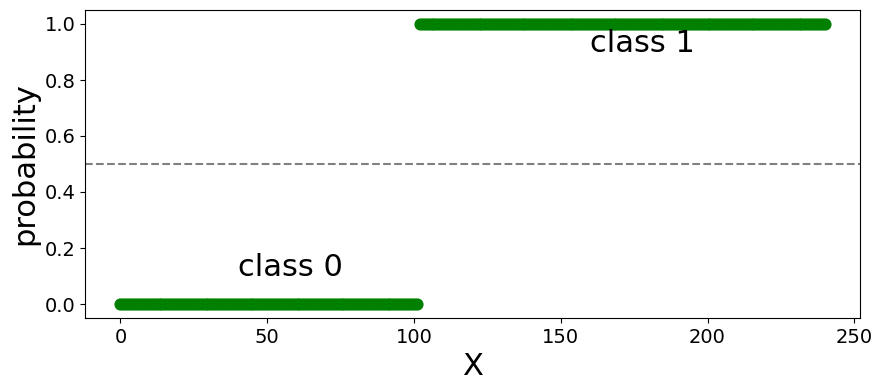

In [43]:
fig, ax = plt.subplots(figsize=(10, 4))
#plt.scatter(X, df.y, color="blue", s=80)
plt.scatter(X, df["logistic_class"], color="green",s=60)
# decoration
plt.axhline(y=0.5, color='grey', linestyle='--')
ax.set_ylabel ("p", fontsize=18)
ax.set_ylabel ("probability", fontsize=22);
ax.set_xlabel ("X", fontsize=22);
ax.text(160, 0.9, "class 1", size=22)
ax.text(40, 0.1, "class 0", size=22);

# Logistic regression: Fit using gradient descent

In [44]:
# Source: https://gist.github.com/Carl-McBride-Ellis/a60fabea3e5e15f560d8e5c33214445e

def gradient_descent(X, y_true, eta=0.1, n_iterations=5_000, tol=0.00002):
    """
    X : a min-max scaled numpy matrix, shape (m_rows, n_feats)
    y_true : a numpy matrix, shape (m_rows, 1)
    returns : beta, shape (n_feats+1, 1)
    """
    # create design matrix from X having a column of 1s for beta_0
    X1 = np.column_stack( (X, np.ones(len(X)) ) )
    # select a random starting point
    rng = np.random.default_rng()
    beta = rng.uniform( size= X1.shape[1] ).reshape(-1,1)
    costs = [] # save the costs for plotting
    n_points = np.shape(y_true)[0]

    for i in range(n_iterations):
        #y_pred = X1 @ beta # linear regression
        y_pred = sigmoid(X1 @ beta) # logistic regression
        error = y_pred - y_true
        # cost == MSE
        cost = np.sum(error**2)/ n_points
        # early stopping
        if (cost) < tol: break
        costs.append(cost) # save for plotting
        gradient = X1.T @ error
        # update the betas
        beta = beta - (eta/ n_points) * gradient

    return beta, costs

def sigmoid(x):
    return 1/(1 + np.exp(-x))

In [45]:
%%time

# Standardize the x values
x_mean = X.mean()
x_std  = X.std()
z = (X - x_mean) / x_std

eta          = 0.01 # step size
n_iterations = 5000 # number of iterations

kappa, costs = gradient_descent(z, y.values.reshape(-1,1), eta, n_iterations)

CPU times: user 48.9 ms, sys: 1.96 ms, total: 50.8 ms
Wall time: 50.1 ms


In [46]:
df["GD_probability"] = sigmoid(kappa[0]*z + kappa[1])

visually compare our gradient descent solution with the scikit logistic regressor solution

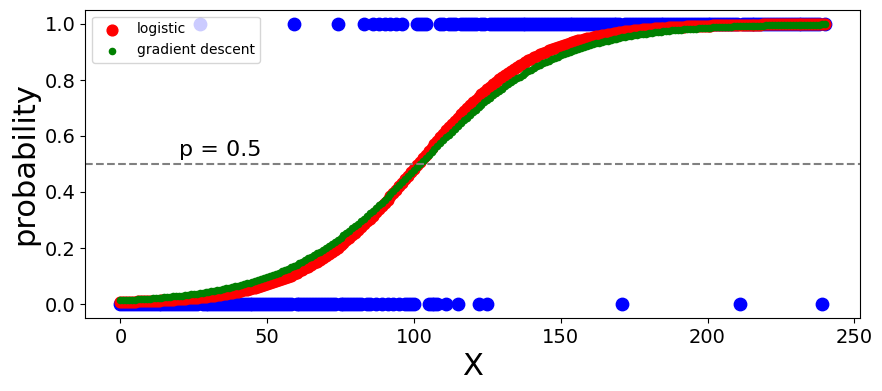

In [47]:
fig, ax = plt.subplots(figsize=(10, 4))
plt.scatter(df["X"], df["y"], color="blue", s=80)
plt.scatter(df["X"], df["logistic_probability"], color="red",s=60, label="logistic")
plt.scatter(df["X"], df["GD_probability"], color="green",s=20, label="gradient descent")
plt.axhline(y=0.5, color='grey', linestyle='--')
ax.set_ylabel ("p", fontsize=18)
ax.set_ylabel ("probability", fontsize=22);
ax.set_xlabel ("X", fontsize=22);
ax.text(20, 0.53, "p = 0.5", size=16)
plt.legend(loc='upper left', fontsize=10);

## Using [statsmodels](https://www.statsmodels.org/stable/index.html)

In [48]:
import statsmodels.api as sm

X1 = sm.add_constant(df["X"])
model   = sm.Logit(df["y"], X1)
results = model.fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.266611
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  241
Model:                          Logit   Df Residuals:                      239
Method:                           MLE   Df Model:                            1
Date:                Tue, 13 Jan 2026   Pseudo R-squ.:                  0.6087
Time:                        19:51:09   Log-Likelihood:                -64.253
converged:                       True   LL-Null:                       -164.20
Covariance Type:            nonrobust   LLR p-value:                 2.210e-45
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.1132      0.703     -7.271      0.000      -6.491      -3.735
X              0.0504      0.